 # Importing libraries 

In [1]:
# Imports needed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For plotting graphs
import matplotlib.pyplot as plt # For image visualization and plotting graphs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 # For loading the dataset
from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle 
import Augmentor

## Loading the dataset

In [2]:
image_size = (150, 150) # Default image size
batch_size = 32
# required for data augmnetation and dataset exploration
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.33)

train_ds = train_datagen.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 4749 images belonging to 50 classes.
Found 2301 images belonging to 50 classes.


## Exploring and visualizing the dataset

### Exploring Train data

In [3]:
count = 0
train_imgs_per_class = {}
for cls in train_ds.class_indices.keys():
    for i in range(len(train_ds.filenames)):
        if cls in train_ds.filenames[i]:
            count += 1
    train_imgs_per_class[cls] = count
    count = 0

In [4]:
train_imgs_per_class

{'Acacia': 93,
 'Adenanthera microsperma': 102,
 'Adenium species': 97,
 'Anacardium occidentale': 161,
 'Annona squamosa': 92,
 'Artocarpus altilis': 92,
 'Artocarpus heterophyllus': 93,
 'Barringtonia acutangula': 93,
 'Cananga odorata': 94,
 'Carica papaya': 139,
 'Casuarina equisetifolia': 95,
 'Cedrus': 96,
 'Chrysophyllum cainino': 90,
 'Citrus aurantiifolia': 90,
 'Citrus grandis': 100,
 'Cocos nucifera': 90,
 'Dalbergia oliveri': 98,
 'Delonix regia': 92,
 'Dipterocarpus alatus': 106,
 'Erythrina fusca': 92,
 'Eucalyptus': 86,
 'Ficus microcarpa': 101,
 'Ficus racemosa': 79,
 'Gmelina arborea Roxb': 93,
 'Hevea brasiliensis': 91,
 'Hopea': 98,
 'Khaya senegalensis': 158,
 'Khaya senegalensis A.Juss': 94,
 'Lagerstroemia speciosa': 96,
 'Magnolia alba': 98,
 'Mangifera': 98,
 'Melaleuca': 92,
 'Melia azedarach': 93,
 'Musa': 89,
 'Nephelium lappaceum': 92,
 'Persea': 93,
 'Polyalthia longifolia': 95,
 'Prunnus': 103,
 'Prunus salicina': 93,
 'Psidium guajava': 82,
 'Pterocarpus 

In [5]:
train_df = pd.Series(train_imgs_per_class) 
train_df.describe()

count     50.000000
mean      98.760000
std       17.468993
min       79.000000
25%       92.000000
50%       94.000000
75%       98.000000
max      161.000000
dtype: float64

Text(0.5, 1.0, 'Number of images per class')

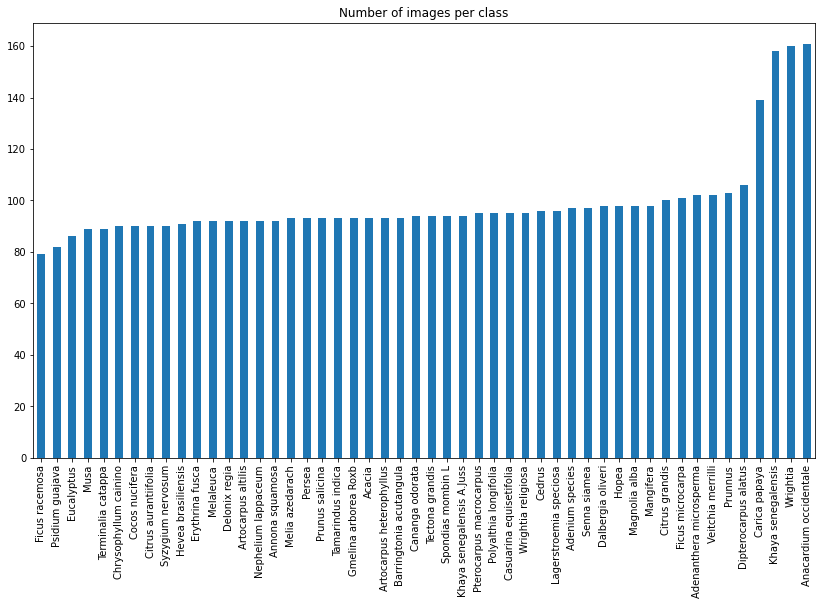

In [6]:
plt.figure(figsize=(14, 8))
train_df.sort_values().plot(kind='bar')
plt.title('Number of images per class')

### Exploring Validation data

In [7]:
count = 0
val_imgs_per_class = {}
for cls in val_ds.class_indices.keys():
    for i in range(len(val_ds.filenames)):
        if cls in val_ds.filenames[i]:
            count += 1
    val_imgs_per_class[cls] = count
    count = 0
val_imgs_per_class

{'Acacia': 45,
 'Adenanthera microsperma': 50,
 'Adenium species': 47,
 'Anacardium occidentale': 78,
 'Annona squamosa': 45,
 'Artocarpus altilis': 44,
 'Artocarpus heterophyllus': 45,
 'Barringtonia acutangula': 45,
 'Cananga odorata': 45,
 'Carica papaya': 68,
 'Casuarina equisetifolia': 46,
 'Cedrus': 47,
 'Chrysophyllum cainino': 43,
 'Citrus aurantiifolia': 44,
 'Citrus grandis': 48,
 'Cocos nucifera': 44,
 'Dalbergia oliveri': 47,
 'Delonix regia': 45,
 'Dipterocarpus alatus': 52,
 'Erythrina fusca': 44,
 'Eucalyptus': 41,
 'Ficus microcarpa': 49,
 'Ficus racemosa': 38,
 'Gmelina arborea Roxb': 45,
 'Hevea brasiliensis': 44,
 'Hopea': 48,
 'Khaya senegalensis': 77,
 'Khaya senegalensis A.Juss': 46,
 'Lagerstroemia speciosa': 47,
 'Magnolia alba': 47,
 'Mangifera': 47,
 'Melaleuca': 44,
 'Melia azedarach': 45,
 'Musa': 43,
 'Nephelium lappaceum': 45,
 'Persea': 45,
 'Polyalthia longifolia': 46,
 'Prunnus': 50,
 'Prunus salicina': 45,
 'Psidium guajava': 40,
 'Pterocarpus macrocar

In [8]:
val_df = pd.Series(val_imgs_per_class)
val_df.describe()

count    50.000000
mean     47.860000
std       8.597603
min      38.000000
25%      44.250000
50%      45.000000
75%      47.000000
max      78.000000
dtype: float64

Text(0.5, 1.0, 'Number of images per class')

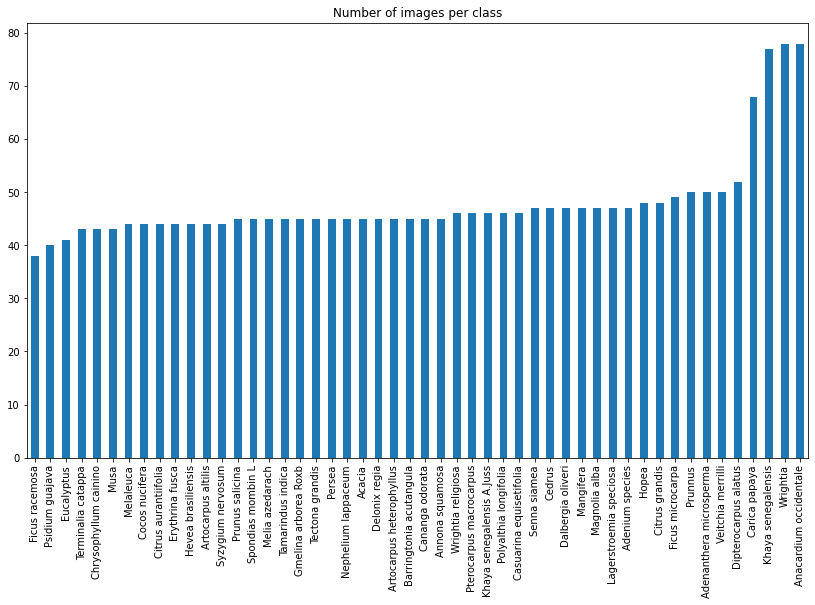

In [9]:
plt.figure(figsize=(14, 8))
(val_df.sort_values()).plot(kind='bar')
plt.title('Number of images per class')

In [10]:
class_names = train_imgs_per_class.keys()
print(class_names)

dict_keys(['Acacia', 'Adenanthera microsperma', 'Adenium species', 'Anacardium occidentale', 'Annona squamosa', 'Artocarpus altilis', 'Artocarpus heterophyllus', 'Barringtonia acutangula', 'Cananga odorata', 'Carica papaya', 'Casuarina equisetifolia', 'Cedrus', 'Chrysophyllum cainino', 'Citrus aurantiifolia', 'Citrus grandis', 'Cocos nucifera', 'Dalbergia oliveri', 'Delonix regia', 'Dipterocarpus alatus', 'Erythrina fusca', 'Eucalyptus', 'Ficus microcarpa', 'Ficus racemosa', 'Gmelina arborea Roxb', 'Hevea brasiliensis', 'Hopea', 'Khaya senegalensis', 'Khaya senegalensis A.Juss', 'Lagerstroemia speciosa', 'Magnolia alba', 'Mangifera', 'Melaleuca', 'Melia azedarach', 'Musa', 'Nephelium lappaceum', 'Persea', 'Polyalthia longifolia', 'Prunnus', 'Prunus salicina', 'Psidium guajava', 'Pterocarpus macrocarpus', 'Senna siamea', 'Spondias mombin L', 'Syzygium nervosum', 'Tamarindus indica', 'Tectona grandis', 'Terminalia catappa', 'Veitchia merrilli', 'Wrightia', 'Wrightia religiosa'])


In [11]:
dict_labels = dict(zip(class_names, list(range(len(class_names)))))
dict_labels

{'Acacia': 0,
 'Adenanthera microsperma': 1,
 'Adenium species': 2,
 'Anacardium occidentale': 3,
 'Annona squamosa': 4,
 'Artocarpus altilis': 5,
 'Artocarpus heterophyllus': 6,
 'Barringtonia acutangula': 7,
 'Cananga odorata': 8,
 'Carica papaya': 9,
 'Casuarina equisetifolia': 10,
 'Cedrus': 11,
 'Chrysophyllum cainino': 12,
 'Citrus aurantiifolia': 13,
 'Citrus grandis': 14,
 'Cocos nucifera': 15,
 'Dalbergia oliveri': 16,
 'Delonix regia': 17,
 'Dipterocarpus alatus': 18,
 'Erythrina fusca': 19,
 'Eucalyptus': 20,
 'Ficus microcarpa': 21,
 'Ficus racemosa': 22,
 'Gmelina arborea Roxb': 23,
 'Hevea brasiliensis': 24,
 'Hopea': 25,
 'Khaya senegalensis': 26,
 'Khaya senegalensis A.Juss': 27,
 'Lagerstroemia speciosa': 28,
 'Magnolia alba': 29,
 'Mangifera': 30,
 'Melaleuca': 31,
 'Melia azedarach': 32,
 'Musa': 33,
 'Nephelium lappaceum': 34,
 'Persea': 35,
 'Polyalthia longifolia': 36,
 'Prunnus': 37,
 'Prunus salicina': 38,
 'Psidium guajava': 39,
 'Pterocarpus macrocarpus': 40,


As the image sample per class is not uniformly distributed, we will create augmented images using **Augmentor pipeline** for those which have less image samples than the average so that our model performs well on validation data (as we will have more validation data).

### Creating more data using image augmentation

In [12]:
# for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")):
#         value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them
#         p = Augmentor.Pipeline("BarkVN-50/BarkVN-50_mendeley/" + folder + '/') # An output folder will be created for each class
#         # Point to a directory containing ground truth data.
#         # Images with the same file names will be added as ground truth data
#         # and augmented in parallel to the original data.
#         p.ground_truth("BarkVN-50/BarkVN-50_mendeley/" + folder + '/')
#         # Add operations to the pipeline as normal:
#         p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
#         p.flip_left_right(probability=0.5)
#         p.zoom_random(probability=0.5, percentage_area=0.8)
#         p.flip_top_bottom(probability=0.5)
#         if train_imgs_per_class[folder] < 93:
#             p.sample(100-train_imgs_per_class[folder])
        

**Reference for the augmentation technique:** https://github.com/mdbloice/Augmentor/blob/master/notebooks/Per_Class_Augmentation_Strategy.ipynb

#### Moving augmented images from output folder to original class folders

In [13]:
# import shutil
# import os
# import glob
# count = 0
# for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")): 
#     ## path to source directory
#     files = glob.glob("BarkVN-50/BarkVN-50_mendeley/" + folder + "/output")
#     #src_dir = r"C:\Users\RIZWAN\Documents\Multiclass Image clasiification\BarkVN-50\BarkVN-50_mendeley" + "/"+ folder + "/output"
#     for image in files:
#         image = cv2.imread(image)
#         count +=1
#         # Save .jpg image
#         cv2.imwrite("BarkVN-50/BarkVN-50_mendeley/" + folder + "/"+'IMG_AUG_{}.JPG'.format(count), image, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
#     # path to destination directory
#     #dest_dir = r"C:\Users\RIZWAN\Documents\Multiclass Image clasiification\BarkVN-50\BarkVN-50_mendeley" + "/" + folder
#     count=0
#     # getting all the files in the source directory
# #     files = os.listdir(src_dir)

# #     shutil.copytree(src_dir, dest_dir)

#### Deleting the output folder

In [14]:
# for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")): 
# # Remove the Directory
#     path = "BarkVN-50/BarkVN-50_mendeley/" + folder + "/output"
#     shutil.rmtree(path)

**Creating custom function to load the dataset**

In [15]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them
        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels


### Loading the dataset using the dataset function

In [16]:
images, labels = dataset('BarkVN-50/BarkVN-50_mendeley/')    # Loading the dataset
images, labels = shuffle(images, labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s]


In [17]:
labels = keras.utils.to_categorical(labels, 50) # Converting labels to (_, 50) shape for model training

### Simple splitting

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

In [20]:
print( x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(4935, 150, 150, 3)
(2115, 150, 150, 3)
(4935, 50)
(2115, 50)


In [21]:
print(np.mean(x_train))
print(np.median(x_train))

0.47622186
0.45882353


In [22]:
print(np.mean(x_val))
print(np.median(x_val))

0.47532824
0.45490196


As the simple train-validation split is resulting into imbalanced image data distribution per class in training set which results into overfitting classes which have higher count of images. We will use **StratifiedShuffleSplit** to deal with this problem.

### Stratified splitting

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

In [24]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)

for train_index, val_index in sss.split(images, labels):
    X_train_data, X_val_data = images[train_index], images[val_index]
    y_train_data, y_val_data = labels[train_index], labels[val_index]



In [25]:
print( X_train_data.shape)
print(X_val_data.shape)
print( y_train_data.shape)

(4935, 150, 150, 3)
(2115, 150, 150, 3)
(4935, 50)


In [26]:
print(np.mean(X_train_data))
print(np.median(X_train_data))

0.47587508
0.45882353


In [27]:
print(np.mean(X_val_data))
print(np.median(X_val_data))

0.47613707
0.45882353


## Model Building

In [ ]:
# resnet_model = tf.keras.applications.ResNet101V2(
#     weights='imagenet', 
#     include_top=False,  
#     input_shape=(150,150,3)
# )
# for layers in resnet_model.layers:
#             layers.trainable=False

In [ ]:
# last_output = resnet_model.layers[-1].output
# x = Flatten()(last_output)
# # x = Dropout(0.3)(x)
# x = Dense(128, activation = 'relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(50, activation = 'softmax')(x)
# final_model_1 = Model(resnet_model.input, x)

In [28]:
base_model = keras.applications.ResNet101V2(include_top=False, input_shape=(150,150,3), weights="imagenet")  # Transfer learning
base_model.trainable = False   # Setting the training of resnet layers to false to fit our data

In [68]:
model_1 = keras.models.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(50, activation='softmax'),
])

In [69]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training the model on the data from Stratified shuffled split

In [70]:
history = model_1.fit(X_train_data, y_train_data, epochs = 50, batch_size = 32, validation_data = (X_val_data, y_val_data))

Epoch 1/50
155/155 [==============================] - 1164s 7s/step - loss: 2.2327 - accuracy: 0.4415 - val_loss: 1.1067 - val_accuracy: 0.7343
Epoch 2/50
155/155 [==============================] - 1070s 7s/step - loss: 0.9694 - accuracy: 0.7358 - val_loss: 0.8021 - val_accuracy: 0.8066
Epoch 3/50
155/155 [==============================] - 1055s 7s/step - loss: 0.7037 - accuracy: 0.8128 - val_loss: 0.6721 - val_accuracy: 0.8288
Epoch 4/50
155/155 [==============================] - 1066s 7s/step - loss: 0.5510 - accuracy: 0.8541 - val_loss: 0.6034 - val_accuracy: 0.8511
Epoch 5/50
155/155 [==============================] - 1072s 7s/step - loss: 0.4641 - accuracy: 0.8841 - val_loss: 0.5656 - val_accuracy: 0.8558
Epoch 6/50
155/155 [==============================] - 1084s 7s/step - loss: 0.3790 - accuracy: 0.9072 - val_loss: 0.5229 - val_accuracy: 0.8771
Epoch 7/50
155/155 [==============================] - 1081s 7s/step - loss: 0.3425 - accuracy: 0.9189 - val_loss: 0.5080 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
preds = model_1.evaluate(X_val_data, y_val_data, batch_size=32)
print ("Loss = " + str(preds[0]))
print ("Valiadtion Accuracy = " + str(preds[1]))

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Training the model on the data from simple train-test split

In [65]:
model_2= keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(50, activation='softmax')
])

In [66]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3 = model_2.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val))

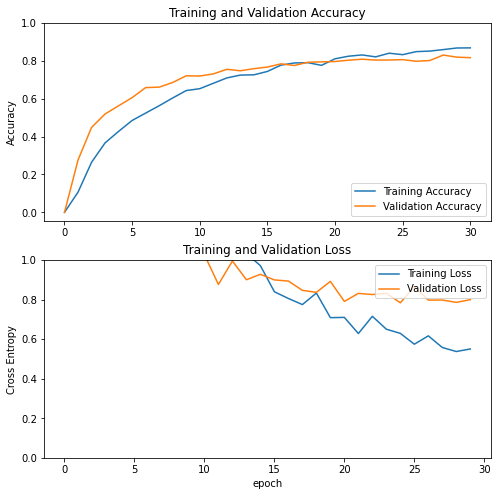

In [57]:
acc = [0.] + history_3.history['accuracy']
val_acc = [0.] + history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.where(y_test == 1)[1], outcomes, target_names=class_names))